In [33]:
from research.interest_rates.scripts.backtesting import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Try XGBoost; fall back to GradientBoosting if not installed
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

def ts_expanding_oos_proba(X: pd.DataFrame, y: pd.Series, model, start_date: str, min_train: int = 120):
    """
    Expanding-window out-of-sample probabilities.
    start_date: first test date. Before that used for initial training.
    min_train: minimum months required to start.
    Returns a pd.Series of predicted probabilities aligned to test dates.
    """
    # Align
    data = pd.concat({"y": y, "X": X}, axis=1).dropna(how="any")
    data = data.loc[data.index >= pd.to_datetime(start_date)]
    full = pd.concat({"y": y, "X": X}, axis=1).dropna(how="any")

    preds, idxs = [], []
    avail_idx = full.index
    for t in data.index:
        train_idx = avail_idx[avail_idx < t]
        if len(train_idx) < min_train:  # require N months
            continue
        X_train = X.loc[train_idx]
        y_train = y.loc[train_idx]
        X_t = X.loc[[t]]

        model.fit(X_train, y_train)
        p = float(model.predict_proba(X_t)[:,1][0])
        preds.append(p); idxs.append(t)

    return pd.Series(preds, index=pd.DatetimeIndex(idxs), name="p_hat")


In [34]:
macro_df = pd.read_csv("../../../data/processed/us_macro_monthly.csv", index_col=0, parse_dates=True)
macro_df.tail()

,DFF,DGS2,DGS10,CPIAUCSL,M2SL,GDPC1,UNRATE,spread_10y_2y,inflation_yoy,m2_growth_yoy,gdp_growth_yoy,real_dff,log_gdp,log_m2,USREC
2025-05-31,4.330000,3.920000,4.423810,320.580,21884.6,NaN,4.2,0.503810,2.375934,4.223796,2.080467,1.954066,NaN,9.993538,0
2025-06-30,4.330000,3.889000,4.383500,321.500,22022.1,NaN,4.1,0.494500,2.672683,4.540578,2.080467,1.657317,NaN,9.999802,0
2025-07-31,4.330000,3.882273,4.391818,322.132,22115.8,NaN,4.2,0.509545,2.731801,4.823657,1.245417,1.598199,NaN,10.004048,0
2025-08-31,4.330000,3.703810,4.264762,323.364,22195.4,NaN,4.3,0.560952,2.939220,4.767929,1.245417,1.390780,NaN,10.007640,0
2025-09-30,4.224667,3.568571,4.120476,324.368,NaN,NaN,NaN,0.551905,3.022700,4.339937,1.245417,1.201967,NaN,NaN,0


In [35]:
yield_curve_df = pd.read_csv("../../../data/processed/yield_curve_factors.csv", index_col=0, parse_dates=True)
yield_curve_df.tail()

,PC1_Level,PC2_Slope,PC3_Curvature
DATE,,,
2025-06-30,-1.110089,1.231662,0.553339
2025-07-31,-1.107968,1.205456,0.572929
2025-08-31,-1.394995,1.176283,0.644525
2025-09-30,-1.737024,1.112223,0.567918
2025-10-31,-1.860474,1.129281,0.521624


In [36]:
import yfinance as yf

# OOS probability series
oos = pd.read_csv("../../../data/processed/recession_prob_12m_oos_multivar.csv",
                  index_col=0, parse_dates=True).rename(columns={"phat":"p_recession","y":"y"})
oos = oos.asfreq("ME")

# download prices and compute monthly returns
start_date = oos.index[0]
tickers = ["SPY", "VFITX"]
px = yf.download(tickers, start=start_date, auto_adjust=True, progress=False)["Close"]
px = px.resample("ME").last()

ret = px.pct_change().dropna()
ret.rename(columns={'SPY': 'ret_eq', 'VFITX': 'ret_bond'}, inplace=True)

df = oos.join(ret, how="inner")
df.tail()

,p_recession,y,ret_eq,ret_bond
2022-06-30,0.996404,0,-0.082460,-0.008271
2022-07-31,0.996713,0,0.092087,0.019216
2022-08-31,0.996134,0,-0.040802,-0.029085
2022-09-30,0.995388,0,-0.092446,-0.032554
2022-10-31,0.992694,0,0.081276,-0.008276


In [37]:
def build_ret_cash_from_rate(df_rate: pd.DataFrame,
                             rate_col: str = "DFF",
                             floor_zero: bool = False) -> pd.Series:
    """
    Monthly cash return using last month's annualized rate.
    ret_cash_{t} = rate_{t-1} / (100*12)
    floor_zero=True will clip negative implied cash to 0 (useful for ZLB artefacts).
    """
    r = df_rate[rate_col].astype(float)
    if floor_zero:
        r = r.clip(lower=0.0)
    ret_cash = (r.shift(1) / 1200.0).rename("ret_cash")  # shift to avoid look-ahead
    return ret_cash

macro_df = macro_df.sort_index()
yield_curve_df = yield_curve_df.sort_index()

ret_cash = build_ret_cash_from_rate(macro_df, rate_col="DFF", floor_zero=True)

# --- 2) Merge macro & PCA factors; add ret_cash ---
df = (
    df.join(macro_df, how='inner')
        .join(yield_curve_df, how="inner")
        .join(ret_cash, how="left")
).rename(columns={'y': 'y_recession_12m'})

# Optional: sanity checks
assert "ret_cash" in df.columns
# cash should be small & positive most of the time
print(df["ret_cash"].describe())
print(df[["DFF","ret_cash"]].tail())

count    309.000000
mean       0.001705
std        0.001758
min        0.000041
25%        0.000121
50%        0.001048
75%        0.003464
max        0.005454
Name: ret_cash, dtype: float64
                 DFF  ret_cash
2022-06-30  1.205000  0.000638
2022-07-31  1.675806  0.001004
2022-08-31  2.330000  0.001397
2022-09-30  2.555000  0.001942
2022-10-31  3.080000  0.002129


In [38]:
df.columns

Index(['p_recession', 'y_recession_12m', 'ret_eq', 'ret_bond', 'DFF', 'DGS2',
       'DGS10', 'CPIAUCSL', 'M2SL', 'GDPC1', 'UNRATE', 'spread_10y_2y',
       'inflation_yoy', 'm2_growth_yoy', 'gdp_growth_yoy', 'real_dff',
       'log_gdp', 'log_m2', 'USREC', 'PC1_Level', 'PC2_Slope', 'PC3_Curvature',
       'ret_cash'],
      dtype='object')

In [39]:
# Example feature list (adjust to match your df)
FEATURES = [
    "PC2_Slope","PC3_Curvature","PC1_Level",
    "spread_10y_2y","inflation_yoy","gdp_growth_yoy","UNRATE","real_dff",
]

# Your target: recession within 12 months (binary)
y = df["y_recession_12m"].astype(int)
X = df[FEATURES].copy()

# Optional: simple standardization for linear model via Pipeline
logit_clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logit", LogisticRegression(max_iter=1000))
])

rf_clf = RandomForestClassifier(
    n_estimators=500, max_depth=4, min_samples_leaf=20, random_state=0
)

if HAS_XGB:
    xgb_clf = XGBClassifier(
        n_estimators=500, max_depth=3, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss", random_state=0
    )
else:
    xgb_clf = GradientBoostingClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=2
    )


In [40]:
START_TEST = "1990-01-01"   # pick your start
p_logit = ts_expanding_oos_proba(X, y, logit_clf, START_TEST)
p_rf    = ts_expanding_oos_proba(X, y, rf_clf,    START_TEST)
p_xgb   = ts_expanding_oos_proba(X, y, xgb_clf,   START_TEST)

# Align with realized labels on test set
y_test = y.reindex(p_logit.index)  # all series share test dates by design; use intersection to be safe
idx = y_test.index.intersection(p_rf.index).intersection(p_xgb.index)
y_test = y_test.reindex(idx)
p_logit = p_logit.reindex(idx)
p_rf    = p_rf.reindex(idx)
p_xgb   = p_xgb.reindex(idx)


In [41]:
def prob_smoothness(p: pd.Series) -> float:
    """Lower mean |Δp| implies smoother probabilities. Return mean absolute month-to-month change."""
    return p.diff().abs().dropna().mean()

def model_stats(y_true: pd.Series, p: pd.Series) -> dict:
    return {
        "AUC": roc_auc_score(y_true, p),
        "Brier": brier_score_loss(y_true, p),
        "Smooth_dP": prob_smoothness(p)
    }

stats_logit = model_stats(y_test, p_logit)
stats_rf    = model_stats(y_test, p_rf)
stats_xgb   = model_stats(y_test, p_xgb)
stats_logit, stats_rf, stats_xgb


({'AUC': 0.8891640866873065,
  'Brier': 0.0839947961229902,
  'Smooth_dP': np.float64(0.019129120855045232)},
 {'AUC': 0.8306501547987616,
  'Brier': 0.08157077196508467,
  'Smooth_dP': np.float64(0.01792475702283456)},
 {'AUC': 0.6959752321981424,
  'Brier': 0.07516368761492168,
  'Smooth_dP': np.float64(0.03950278531420265)})

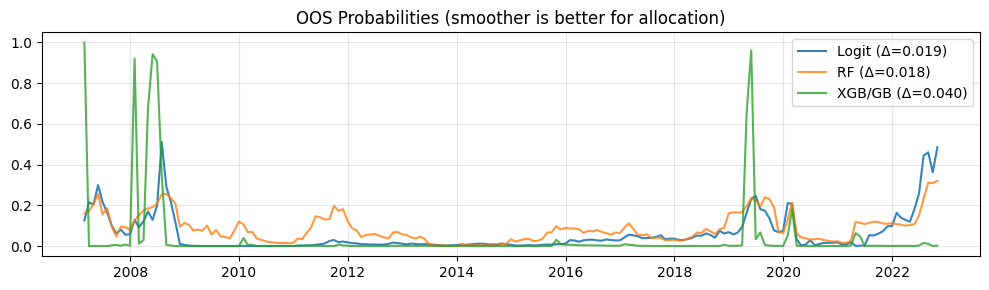

In [42]:
plt.figure(figsize=(10,3))
plt.plot(p_logit, label=f"Logit (Δ={prob_smoothness(p_logit):.3f})", alpha=0.9)
plt.plot(p_rf,    label=f"RF (Δ={prob_smoothness(p_rf):.3f})", alpha=0.8)
plt.plot(p_xgb,   label=f"XGB/GB (Δ={prob_smoothness(p_xgb):.3f})", alpha=0.8)
plt.legend(); plt.title("OOS Probabilities (smoother is better for allocation)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Logit: {'annual_return': np.float64(0.05448173124315914), 'annual_vol': np.float64(0.1497982889906133), 'sharpe': np.float64(0.6562134900253367), 'sortino': np.float64(0.7490205253794204), 'max_drawdown': -0.4588372682468612, 'max_dd_years': 3.25, 'turnover': np.float64(0.004683630098299794)}
RF   : {'annual_return': np.float64(0.05326701821527702), 'annual_vol': np.float64(0.14646872146631362), 'sharpe': np.float64(0.6548401427734692), 'sortino': np.float64(0.7457875063668195), 'max_drawdown': -0.45384561545977253, 'max_dd_years': 3.4166666666666665, 'turnover': np.float64(0.005085819904264066)}
XGB/GB: {'annual_return': np.float64(0.058516898914980464), 'annual_vol': np.float64(0.14946040376057967), 'sharpe': np.float64(0.6993915360025772), 'sortino': np.float64(0.8128411592745302), 'max_drawdown': -0.4192155602077313, 'max_dd_years': 3.0833333333333335, 'turnover': np.float64(0.016632716786964517)}


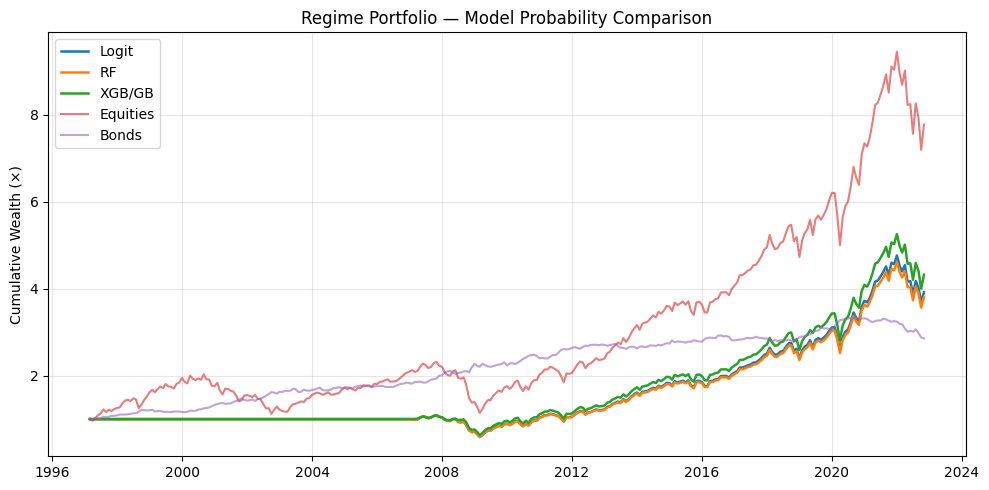

In [43]:
def run_with_probability(prob: pd.Series, df: pd.DataFrame, cfg: RegimeConfig):
    df_use = df.copy()
    df_use["p_recession"] = prob.reindex(df_use.index).ffill()  # align & ffill at month-end
    res = build_portfolio_returns(df_use, cfg)
    mets = evaluate(res["r_port"], res["w_bond"])
    return res, mets

cfg07 = RegimeConfig(
    lambda_prob=0.7, p_ewma_halflife=3,
    up=0.6, down=0.5, confirm=2,
    mom_lookback_m=6, use_cash_filter=True,
    vol_target_ann=None
)

res_logit, m_logit = run_with_probability(p_logit, df, cfg07)
res_rf,    m_rf    = run_with_probability(p_rf,    df, cfg07)
res_xgb,   m_xgb   = run_with_probability(p_xgb,   df, cfg07)

print("Logit:", m_logit)
print("RF   :", m_rf)
print("XGB/GB:", m_xgb)

# Plot cumulative returns for the three variants
def plot_model_compare(res_list, labels, df):
    plt.figure(figsize=(10,5))
    for res, lab in zip(res_list, labels):
        plt.plot((1+res["r_port"].fillna(0)).cumprod(), label=lab, linewidth=1.8)
    plt.plot((1+df["ret_eq"]).cumprod(), label="Equities", alpha=0.6)
    plt.plot((1+df["ret_bond"]).cumprod(), label="Bonds", alpha=0.6)
    plt.title("Regime Portfolio — Model Probability Comparison")
    plt.ylabel("Cumulative Wealth (×)")
    plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plot_model_compare(
    [res_logit, res_rf, res_xgb],
    ["Logit", "RF", "XGB/GB"],
    df
)
